In [2]:
import gym
import random
from itertools import count
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
torch.manual_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), action, reward, np.array(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [48]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(DQN, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.fc1 = nn.Linear(self.state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, self.action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
    

class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(DuelingDQN, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.fc1 = nn.Linear(self.state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        self.value = nn.Linear(hidden_dim, 1)
        self.advantage = nn.Linear(hidden_dim, self.action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        value = self.value(x)
        advantage = self.advantage(x)

        return value + advantage - advantage.mean()
    

class DuelingDQNAgent:
    def __init__(self, env, state_dim, action_dim, hidden_dim=64, lr=1e-3, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, tau=1e-2, batch_size=64, capacity=10000):
        self.env = env
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.tau = tau
        self.batch_size = batch_size
        self.capacity = capacity

        # self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = torch.device('cpu')
        self.memory = ReplayBuffer(self.capacity)

        self.dqn = DuelingDQN(self.state_dim, self.action_dim, self.hidden_dim).to(self.device)
        self.target = DuelingDQN(self.state_dim, self.action_dim, self.hidden_dim).to(self.device)
        self.target.load_state_dict(self.dqn.state_dict())
        self.target.eval()

        self.optimizer = Adam(self.dqn.parameters(), lr=self.lr)
        self.loss = nn.MSELoss()

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        return np.argmax(self.dqn(state).cpu().detach().numpy())

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        current_q = self.dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q = self.target(next_states).max(1)[0]
        target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = self.loss(current_q, target_q.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_target(self):
        for param, target_param in zip(self.dqn.parameters(), self.target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def train(self, episodes=1000, render=False):
        scores = []
        losses = []
        scores_window = deque(maxlen=100)
        for episode in range(episodes):
            state = self.env.reset()
            score = 0
            loss = 0
            for step in count():
                if render:
                    self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                self.memory.push(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break
                if self.update() is not None:
                    loss += self.update()
                self.update_target()
            scores_window.append(score)
            scores.append(score)
            losses.append(loss / step)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
            if episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        return scores, losses
    
    def test(self, episodes=10):
        scores = []
        for episode in range(episodes):
            state = self.env.reset()
            score = 0
            for step in count():
                self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                state = next_state
                score += reward
                if done:
                    break
            scores.append(score)
        return scores
    
    def save(self, filename):
        torch.save(self.dqn.state_dict(), filename)


Episode 0	Average Score: 48.00
Episode 100	Average Score: 36.29
Episode 200	Average Score: 72.46
Episode 300	Average Score: 87.08
Episode 399	Average Score: 150.45

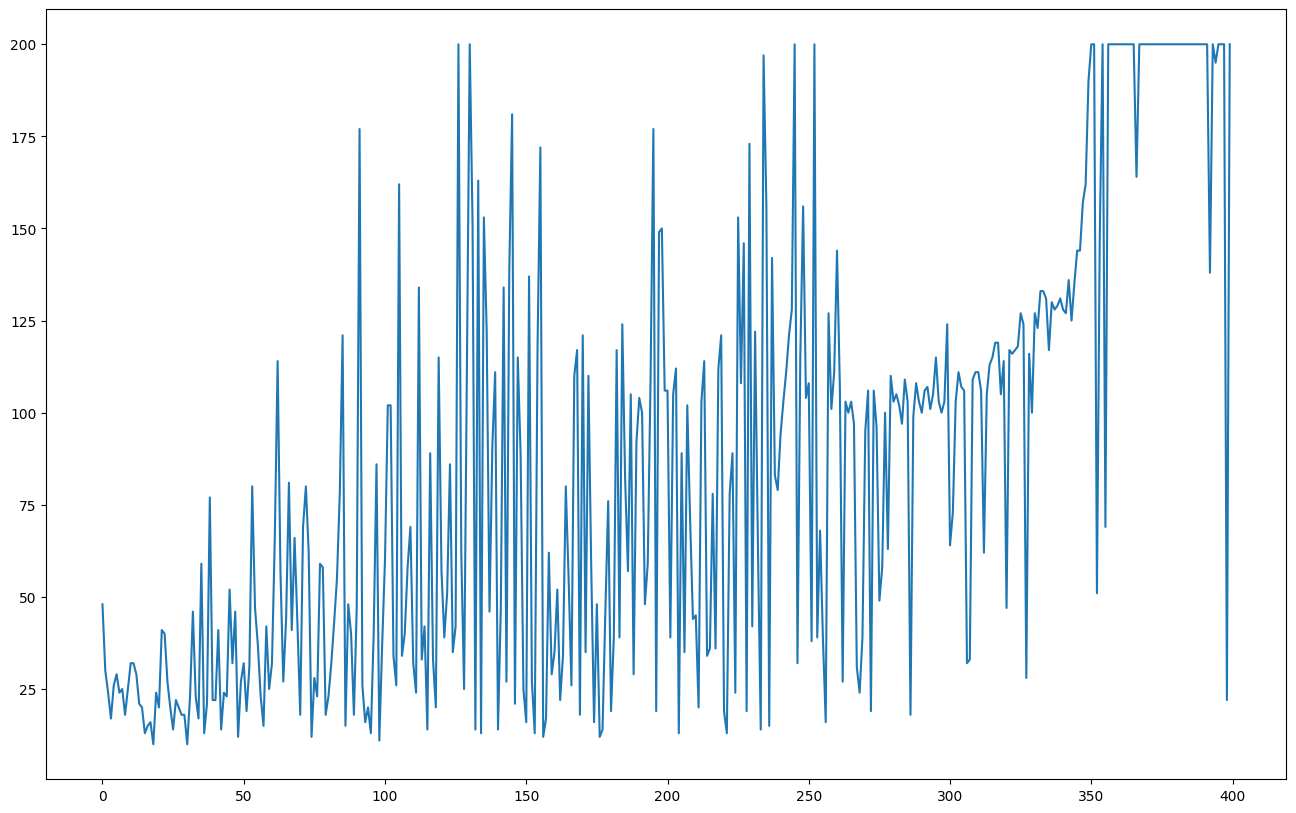

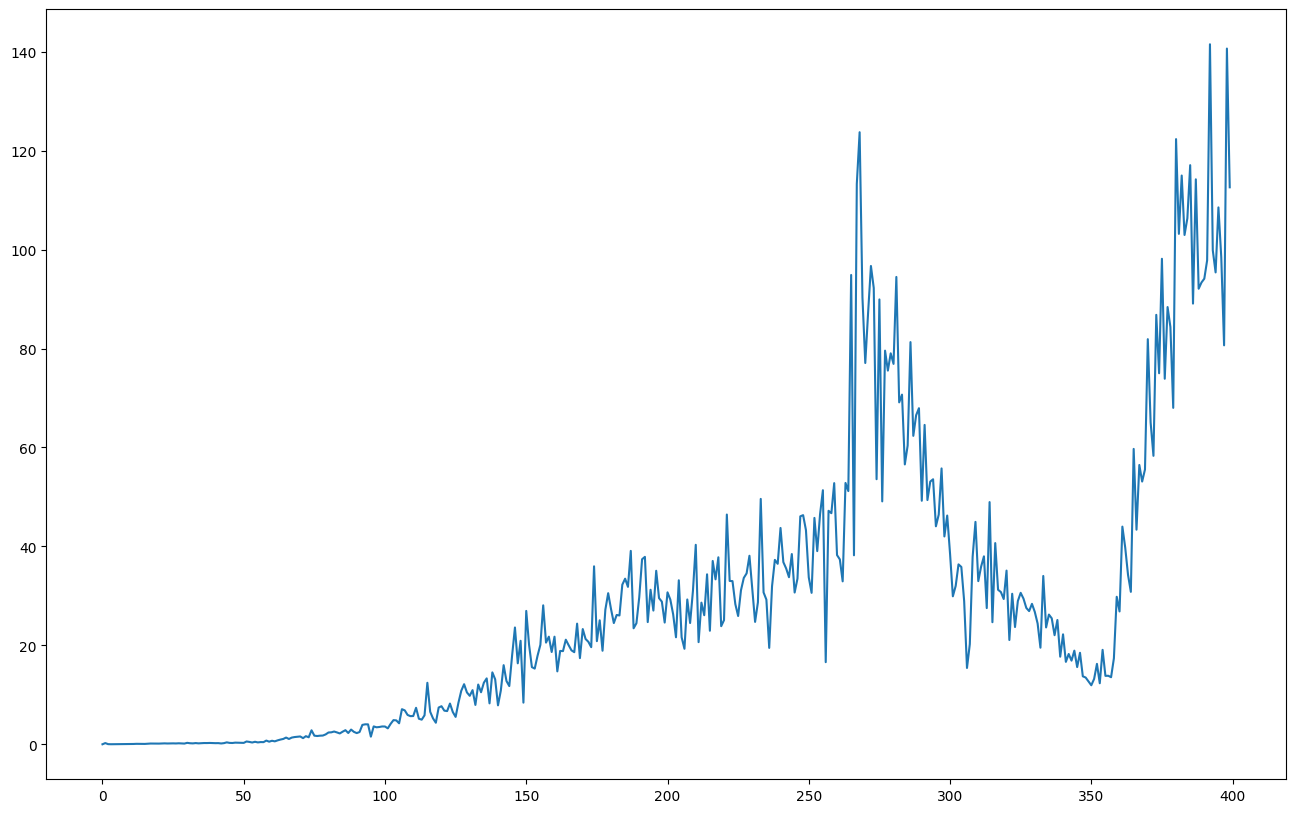

In [49]:
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DuelingDQNAgent(env, state_dim, action_dim)

scores, losses = agent.train(episodes=400)

plt.plot(scores)
plt.show()

plt.plot(losses)
plt.show()
env.close()

agent.save('dueling_dqn_cart.pth')

In [94]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

video = VideoRecorder(env, path='./video/cartpole.mp4')
state = env.reset()
agent = DuelingDQNAgent(env, state_dim, action_dim)
agent.dqn.load_state_dict(torch.load('dueling_dqn_cart.pth'))


for i in range(1000):
    env.render()
    video.capture_frame()
    action = agent.act(state)
    state, reward, done, _ = env.step(action)
    if done:
        break

video.close()


In [95]:
env2 = gym.make('LunarLander-v2')
state_dim2 = env2.observation_space.shape[0]
action_dim2 = env2.action_space.n

agent2 = DuelingDQNAgent(env2, state_dim2, action_dim2)

scores2, losses2 = agent2.train(episodes=1000)

plt.plot(scores2)
plt.show()

average_score = []
for i in range(0, len(scores2), 10):
    average_score.append(np.mean(scores2[i:i+10]))
plt.plot(average_score)
plt.show()

plt.plot(losses2)
plt.show()

Episode 0	Average Score: -95.16
Episode 100	Average Score: -112.56
Episode 200	Average Score: -46.180
Episode 300	Average Score: -111.55
Episode 327	Average Score: -109.68